<h3>Genetic algorithm </h3>

First we read graph and costs for tasks.

In [1]:
graphName = "graphs/testGraph.txt"
costsName = "graphs/testGraphcosts.txt"

In [2]:
from collections import defaultdict

# Nodes in DAG that are represented as (node, [list of ancestor])
def getImmediateAncestors(filename):
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        
        # Dummy nodes source and super sink that are added to represent start and end of project
        sourceNodes = set()
        superSinkNodes = set()
        removeFromeSource = set()
        removeFromSuperSink = set()
        
        # Necessary representation for networkx to draw graph
        GxNodes = set()
        GxEdges = []
            
        for line in file:
            # from represented direceted edges as (node ancestor) we get all ancestors
            node, ancestor = line.split()
            
            GxEdges.append((node, ancestor))
            
            nodes[node].append(ancestor)
            sourceNodes.add(node)
            superSinkNodes.add(ancestor)
            removeFromeSource.add(ancestor)
            removeFromSuperSink.add(node)
        
        for node in removeFromeSource:
            sourceNodes.discard(node)
        for node in removeFromSuperSink:
            superSinkNodes.discard(node)
            
        nodes['s'] = list(sourceNodes)
        nodes['ss'] = [None]
        for node in superSinkNodes:
            nodes[node].append('ss')
            GxEdges.append((node, 'ss'))
        
        for s in sourceNodes:
            GxEdges.append(('s', s))
        GxNodes = list(sourceNodes)
        
#         for node in nodes:
#             print(node, nodes[node])

        # return values are directed acyclic graph represened as dictionary with nodes and their ancestors
        # and GxNodes, GxEdges which is needed representation of graph for drawing
        return nodes, GxNodes, GxEdges

In [3]:
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)

In [4]:
def getCost(filename):
    
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        currentNode = -1
        
        for line in file:
            values = line.split()
            if values[0] == 'n':
                currentNode = values[1]
                nodes[currentNode] = []
            for index in range(2, len(values)):
                duration, cost = values[index].split(',')
                duration = int(duration[1:])
                cost = int(cost[:-1])
                nodes[currentNode].append((duration, cost))

        return nodes

In [5]:
costs = getCost(costsName)
costs

defaultdict(list,
            {'1': [(2, 20), (5, 8)],
             '2': [(3, 8)],
             '3': [(1, 20), (2, 10), (4, 5)],
             's': [(0, 0)],
             'ss': [(0, 0)]})

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def drawGraph(GxNodes, GxEdges):
    # init empty graph
    Gx = nx.Graph()
    # add starting node
    Gx.add_nodes_from('s')
    # add list of remaining nodes
    Gx.add_nodes_from(GxNodes)
    # add edges
    Gx.add_edges_from(GxEdges)
    nx.draw_networkx(Gx,node_size=900, arrows=True, arrowstyle='-|>')

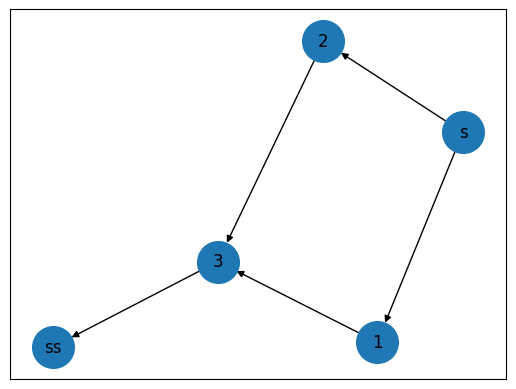

In [7]:
drawGraph(GxNodes, GxEdges)

Then we set needed parameters for genetic algorithm and Idividual with its hromosome represented as steps. Parameters are later added as algorithm parameters.

In [8]:
# TOURNAMENT_SIZE = 10
# POPULATION_SIZE = 100
# MUTATION_RATE = 0.03
# NUM_GENERATIONS = 100
# ELITISIM_SIZE = 20
# BUDGET = 30

In [9]:
import random
import numpy as np

class Individual:
    
    def __init__(self, graph, costs, budget):
        self.budget = budget
        self.graph = graph
        self.costs = costs
        self.steps = self.initSteps()
        self.fitness = self.calcFitness()
    
    def isFeasible(self, steps):
        return self.budgetValue(steps) < self.budget
        
    def initSteps(self):
        solution = [0 for _ in range(len(costs))]

        for node in self.costs:
            if node == 's' or node == 'ss':
                continue
            solution[int(node)] = random.randrange(len(costs[node]))
        if not self.isFeasible(solution):
            self.correctNonFeasible(solution)
        return solution
    def budgetValue(self, steps):
        cost = 0
        for index in range(1, len(steps)-1):
            cost += self.costs[str(index)][steps[index]][1]
        return cost
        
    def __lt__(self,other):
#         print(self.fitness, other.fitness, self.fitness < other.fitness)
        return self.fitness < other.fitness
    
    def calcFitness(self):
        return 1 / self.solutionValue(self.graph['s'], 0)
    
    def solutionValue(self, nodes, earliestStartTime):
        if nodes == []:
            return earliestStartTime
        durations = set()
        newNodes = set()
    #     print(nodes)
        for node in nodes:
    #         print(node)
            if node == 'ss':
                durations.add(0)
                continue
            step = self.steps[int(node)]
            durations.add(costs[node][step][0])
            for ancestor in self.graph[node]:
                newNodes.add(ancestor)
        earliestStartTime += max(durations)
        return self.solutionValue(list(newNodes), earliestStartTime)
    import numpy as np

    def correctNonFeasible(self, solution):
        costs = self.costs
        budget = self.budget
        solutionValue = self.budgetValue(solution)
        if solutionValue < budget:
            return

        difference = budget - solutionValue
        solutionCosts = []

        solutionCosts.append(0)
        for i in range(1, len(solution)-1):
            solutionCosts.append(costs[str(i)][solution[i]][1])
        solutionCosts.append(0)

        for i in range(1, len(solution)-1):
            argMax = np.argmax(solutionCosts)
            for j in range(len(costs[str(argMax)])):
                if costs[str(argMax)][j][1] < costs[str(argMax)][solution[argMax]][1]:
                    solution[argMax] = j
            if self.budgetValue(solution) < budget:
                return solution
            solutionCosts[argMax] = 0
        else:
            print("Ne moze se popraviti")

In [10]:
def selection(population, TOURNAMENT_SIZE):
    bestFitness = float('-inf')
    index = -1
    for i in range(TOURNAMENT_SIZE):
        randomIndividual = random.randrange(len(population))
        if population[randomIndividual].fitness < bestFitness:
            bestFitness = population[randomIndividual].fitness
            index = randomIndividual
    return index 

In [11]:
def crossover(parent1, parent2, child1, child2):
    breakpoint = random.randrange(len(parent1.steps))
    
    child1.steps[:breakpoint] = parent1.steps[:breakpoint]
    child2.steps[:breakpoint] = parent2.steps[:breakpoint]
    
    child1.steps[breakpoint:] = parent2.steps[breakpoint:]
    child2.steps[breakpoint:] = parent1.steps[breakpoint:]
    
    child1.correctNonFeasible(child1.steps)
    child2.correctNonFeasible(child2.steps)

In [12]:
def mutation(individual, costs, MUTATION_RATE):
    for i in range(1, len(individual.steps)-1):
        if random.random() < MUTATION_RATE:
            step = random.randrange(len(costs[str(i)]))
            individual.steps[i] = step
    individual.correctNonFeasible(individual.steps)

In [13]:
def ga(nodes, costs, TOURNAMENT_SIZE = 10, POPULATION_SIZE = 100, MUTATION_RATE = 0.03, NUM_GENERATIONS = 100, ELITISIM_SIZE = 20, BUDGET = 30):
    population = [Individual(nodes, costs, BUDGET) for _ in range(POPULATION_SIZE)]
    newPopulation = [Individual(nodes, costs, BUDGET) for _ in range(POPULATION_SIZE)]

    for i in range(NUM_GENERATIONS):
        population = sorted(population, reverse=True)
        newPopulation[:ELITISIM_SIZE] = population[:ELITISIM_SIZE]
        for j in range(ELITISIM_SIZE, POPULATION_SIZE, 2):
            parent1Index = selection(population, TOURNAMENT_SIZE)
            parent2Index = selection(population, TOURNAMENT_SIZE)

            crossover(population[parent1Index], population[parent2Index], newPopulation[j], newPopulation[j+1])

            mutation(newPopulation[j], costs, MUTATION_RATE)
            mutation(newPopulation[j+1], costs, MUTATION_RATE)

            newPopulation[j].fitness = newPopulation[j].calcFitness()
            newPopulation[j+1].fitness = newPopulation[j+1].calcFitness()

        population = newPopulation


    bestIndividual = max(population)
    
    return (1 / bestIndividual.fitness, bestIndividual.steps, bestIndividual.budgetValue(bestIndividual.steps))

In [14]:
ga(nodes, costs)

(7.0, [0, 1, 0, 1, 0], 26)

In [ ]:
import time

graphNames = ["testGraph", "graph1","graph2", "graph3", "graph4", "graph5", "graph6", "graph7", "graph8", "graph10"]
graphBudget = [30, 10000, 3600, 4000, 8750, 5200, 7100, 7100, 2500, 3300]

minimalDurations = []

for generationSize in [100, 500, 1000, 5000, 10000]:
    for i in range(len(graphNames)):
        nodes, GxNodes, GxEdges = getImmediateAncestors("graphs/" + graphNames[i] + ".txt") 
        costs = getCost("graphs/" + graphNames[i] + "costs" + ".txt")
    
        start = time.perf_counter()
        duration, solution, projectCost = ga(nodes, costs, NUM_GENERATIONS=generationSize, BUDGET=graphBudget[i])
        print("Solution: ", solution)
        print("Duration: ", duration)
        print("Cost: ", projectCost)        
        end = time.perf_counter()
        executionTime = end - start
        print("Time needed for Genetic Algorithm execution: " + str(executionTime))
        minimalDurations.append(duration)

        print()
    plt.plot(range(len(graphNames)), minimalDurations, '-o', label=generationSize)
    plt.legend(loc='upper left')
    minimalDurations = []
    
plt.xlabel("Graph of execution")
plt.ylabel("Project duration")
plt.show()

Solution:  [0, 1, 0, 1, 0]
Duration:  7.0
Cost:  26
Time needed for Genetic Algorithm execution: 0.08357699900079751

Solution:  [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0]
Duration:  29.0
Cost:  6949
Time needed for Genetic Algorithm execution: 1.0292610519973096

Solution:  [0, 0, 0, 1, 1, 1, 0, 2, 1, 3, 0, 0, 0, 3, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0]
Duration:  25.0
Cost:  2579
Time needed for Genetic Algorithm execution: 0.8888737610031967

Solution:  [0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 0, 2, 2, 0, 2, 1, 0, 0, 2, 0, 1, 2, 0]
Duration:  30.0
Cost:  2566
Time needed for Genetic Algorithm execution: 0.9922135909982899

Solution:  [0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 3, 1, 0, 2, 0, 0, 2, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 

Solution:  [0, 2, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0]
Duration:  25.0
Cost:  2575
Time needed for Genetic Algorithm execution: 36.80321925499811

Solution:  [0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Duration:  22.0
Cost:  3276
Time needed for Genetic Algorithm execution: 45.50548305800112

Solution:  [0, 3, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 3, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0]
Duration:  58.0
Cost:  5955
Time needed for Genetic Algorithm execution: 213.26500429299995

Solution:  [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0]
Durati

In [ ]:
def changeSolution(solution, costs, graph):
#     print("changeSolution", solution)
    changeStep = random.randrange(1, len(solution) - 1)
    step = random.randrange(len(costs[str(changeStep)]))
    if step == solution[changeStep]:
        return changeSolution(solution, costs, graph)
    else:
        oldValue = solution[changeStep]
        solution[changeStep] = step
#         print("changeSolution", solution)
        return (changeStep, oldValue)

In [ ]:
def simulatedAnnealing(individual, costs, nodes, iters, budget):
    for i in range(1, iters + 1):
        step, oldValue = changeSolution(individual.steps, costs, nodes)
        if not individual.isFeasible(individual.steps):
            individual.steps[step] = oldValue
        else:
            newValue = individual.calcFitness()
            if newValue < individual.fitness:
                individual.fitness = newValue
            else:
                p = 1.0 / i ** 0.5
                q = random.uniform(0, 1)
                if p > q:
                    individual.fitness = newValue
                else:
                    individual.steps[step] = oldValue

In [ ]:
def gaSimulatedAnnealing(nodes, costs, TOURNAMENT_SIZE = 10, POPULATION_SIZE = 100, MUTATION_RATE = 0.03, NUM_GENERATIONS = 100, ELITISIM_SIZE = 40, BUDGET = 30):
    population = [Individual(nodes, costs, BUDGET) for _ in range(POPULATION_SIZE)]
    newPopulation = [Individual(nodes, costs, BUDGET) for _ in range(POPULATION_SIZE)]

    for i in range(NUM_GENERATIONS):
        population = sorted(population, reverse=True)
        newPopulation[:ELITISIM_SIZE] = population[:ELITISIM_SIZE]
        for j in range(ELITISIM_SIZE, POPULATION_SIZE, 2):
            parent1Index = selection(population, TOURNAMENT_SIZE)
            parent2Index = selection(population, TOURNAMENT_SIZE)

            crossover(population[parent1Index], population[parent2Index], newPopulation[j], newPopulation[j+1])

            mutation(newPopulation[j], costs, MUTATION_RATE)
            mutation(newPopulation[j+1], costs, MUTATION_RATE)

            newPopulation[j].fitness = newPopulation[j].calcFitness()
            newPopulation[j+1].fitness = newPopulation[j+1].calcFitness()
#         print("pre", max(newPopulation).steps)
        simulatedAnnealing(max(newPopulation), costs, nodes, 10, BUDGET)
#         print("posle", max(newPopulation).steps)
        
        population = newPopulation


    bestIndividual = max(population)
    
    return (1 / bestIndividual.fitness, bestIndividual.steps, bestIndividual.budgetValue(bestIndividual.steps))

In [ ]:
graphName = "graphs/testGraph.txt"
costsName = "graphs/testGraphcosts.txt"
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)
costs = getCost(costsName)

duration, solution, budget = gaSimulatedAnnealing(nodes, costs, BUDGET = 2000)

In [ ]:
import time

graphNames = ["testGraph", "graph1","graph2", "graph3", "graph4", "graph5", "graph6", "graph7", "graph8", "graph10"]
graphBudget = [30, 10000, 3600, 4000, 8750, 5200, 7100, 7100, 2500, 3300]

minimalDurations = []

for generationSize in [10, 50, 100, 500, 1000]:
    for i in range(len(graphNames)):
        nodes, GxNodes, GxEdges = getImmediateAncestors("graphs/" + graphNames[i] + ".txt") 
        costs = getCost("graphs/" + graphNames[i] + "costs" + ".txt")
    
        start = time.perf_counter()
        duration, solution, projectCost = gaSimulatedAnnealing(nodes, costs, NUM_GENERATIONS=generationSize, BUDGET=graphBudget[i])
        print("Solution: ", solution)
        print("Duration: ", duration)
        print("Cost: ", projectCost)        
        end = time.perf_counter()
        executionTime = end - start
        print("Time needed for genetic algorithm with simulated annealing execution: " + str(executionTime))
        minimalDurations.append(duration)

        print()
    plt.plot(range(len(graphNames)), minimalDurations, '-o', label=generationSize)
    plt.legend(loc='upper left')
    minimalDurations = []
    
plt.xlabel("Graph of execution")
plt.ylabel("Project duration")
plt.show()